<a href="https://colab.research.google.com/github/ashikshafi08/cogito_ai/blob/main/Fresh_Notebook_Cogito_Ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the stuffs we need 
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import shutil
import sys 

from tensorflow.keras import layers 

# Experimentations to carry out: 
- [x] Convert the mp3 /wav files to wav file so they can be in one standard format. 
- [ ] Figure out how to to build a model with wav file 
- [ ] Can easily build a model if I figure out a way to get all the wav tensors into one shape (check out Ragged Tensors) 
- [ ] Convert the wav files to a 2D image (they will be of different shapes still). 
- [ ] Find an efficient way to append the labels to the corresponding images while converting them from sound waves to image (spectrogram)  
- [ ] Build a Image Classification model with 2D Spectrogram with TensorFlow 
- [ ] Build a Image Classification model with 2D Spectrogram with Fastai 



**Make this notebook readable unlike the older one**


## Loading in the data and preprocessing it 

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/Shareddrives/Tabata/cogito challenge /dbb3bd26ead211eb.zip"

In [4]:
pd.set_option('display.max_colwidth' , None)

In [5]:
# Importing the csv files 
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')
submission_df = pd.read_csv('/content/dataset/sample_submission.csv')

In [6]:
train_df.head()

,filename,emotion
0,18777.mp3,neutral
1,24041.mp3,neutral
2,1621.mp3,joy
3,28883.mp3,neutral
4,14918.mp3,neutral


In [7]:
# Defining the paths 
train_path = '/content/dataset/TrainAudioFiles/'
test_path = '/content/dataset/TestAudioFiles'

# How many files are there in each 
len(os.listdir(train_path)) , len(os.listdir(test_path))

(5816, 2492)

In [8]:
# Making a copy of the dataframe 
train_df_new = train_df.copy()
train_df.shape , train_df_new.shape

((5816, 2), (5816, 2))

In [9]:
# Preprocessing function that gives us the path with wav file extension 
def preprocess_dataframe_mp3_wav_file(df , base_path = '/content/dataset/TrainAudioFiles/'):
  return df['filename'].apply(lambda x: base_path + x)

In [10]:
# Applying the above preprocess function to our train csv 
train_df_new['full_path'] = preprocess_dataframe_mp3_wav_file(train_df_new)
train_df['full_path'] = preprocess_dataframe_mp3_wav_file(train_df)
train_df_new.head(10)

,filename,emotion,full_path
0,18777.mp3,neutral,/content/dataset/TrainAudioFiles/18777.mp3
1,24041.mp3,neutral,/content/dataset/TrainAudioFiles/24041.mp3
2,1621.mp3,joy,/content/dataset/TrainAudioFiles/1621.mp3
3,28883.mp3,neutral,/content/dataset/TrainAudioFiles/28883.mp3
4,14918.mp3,neutral,/content/dataset/TrainAudioFiles/14918.mp3
5,25793.mp3,neutral,/content/dataset/TrainAudioFiles/25793.mp3
6,8382.mp3,joy,/content/dataset/TrainAudioFiles/8382.mp3
7,50666.wav,disgust,/content/dataset/TrainAudioFiles/50666.wav
8,28471.mp3,surprise,/content/dataset/TrainAudioFiles/28471.mp3
9,1459.mp3,neutral,/content/dataset/TrainAudioFiles/1459.mp3


In [11]:
# Getting rid of the 18 the index which is a potential bug 
train_df_new.drop(index = 18 , axis = 1 , inplace = True)

In [12]:
# Removing the bug file from the dataset 
os.remove('/content/dataset/TrainAudioFiles/38543.wav')
len(os.listdir(train_path))

5815

In [ ]:
# Removing the folder and creating new one (Mess!)

# shutil.rmtree('/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles')
# !mkdir '/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles'

### Converting the mp3/wav files to wav files 


In [ ]:
# Importing pydub for converting our files to standard wav file format 
#!pip install pydub 

from pydub import AudioSegment

ModuleNotFoundError: ignored

In [ ]:
# Converting mp3 to wav file and storing them into a dedicated directory (Putting into a function)
from tqdm import tqdm 
from shutil import copyfile

def wav_file_conversion(df , dest = '/content/drive/MyDrive/Cogito_ai/train_wav_files'):
  '''
  Arguments:
  ----------
    * dest : The destination folder where you want to save your converted files 
    * df : dataframe (train or test)

  Returns: 
  --------
    The function returns the converted wav file, if its an mp3 it process the conversion. 
    if its an wav file it just append that file to the destination folder
  '''
  for file_path in tqdm(df['full_path']):
    if file_path[-3:] == 'mp3':
      sound = AudioSegment.from_mp3(file_path)
      sound.export(out_f = f"{dest + '/'+ file_path[17:-4] + '.wav'}" , format = 'wav')
    elif file_path[-3:] == 'wav':
      copyfile(src= file_path , dst= f"{dest + '/'+ file_path[17:-4] + '.wav'}")


In [ ]:
# Checking both the df (should be 5815) and the directory(should be 0)
train_df_new.shape[0] , len(os.listdir('/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles'))

KeyboardInterrupt: ignored

In [ ]:
# Using the above function for the conversion 
wav_file_conversion(df = train_df_new)

After the conversion there should **5815** files, because we just got rid of the bug file. 

In [ ]:
# Checking the destination folder whether there are right number of files (should be 5815)
len(os.listdir('/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles'))

In [ ]:
# Writing a function that will take in the filename and returns a list of duration of the wav files
import random 
import soundfile as sf 

# Defining the path and a empty list

train_wav_filenames = os.listdir('/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles')
wav_duration_list = []

def get_duration(wav_filenames , append_path = '/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles/'):
  '''
  Arguments
  ---------
    * wav_filenames : List of filenames (1833.wav...) 
    * append_path: the complete path name to the directory except the filename

  Returns
  -------
    * wav_duration_list : a list of duration of the wave files (size should be 5815)
  '''
  for filename in tqdm(wav_filenames):
    wav_path = append_path + filename

    # Getting the duration of the wav file 
    f = sf.SoundFile(wav_path)
    sec = f.frames / f.samplerate
    wav_duration_list.append(sec)

  return wav_duration_list

In [ ]:
wav_duration_list = get_duration(train_wav_filenames)
len(wav_duration_list)

In [ ]:
# Looking into our wav file duration list 
wav_duration_list[:20]

In [ ]:
# Get the max, min , median and the mean of the durations
print(f'Maximum duration: {np.max(wav_duration_list)}')
print(f'Minimum duration: {np.min(wav_duration_list)}')
print(f'The median duration: {np.median(wav_duration_list)}')
print(f'The mean duration: {np.mean(wav_duration_list)}')

In [ ]:
# Converting all the seconds to milli-seconds 
wav_duration_milli = [round(sec * 1000) for sec in wav_duration_list]

len(wav_duration_list) , len(wav_duration_milli)

In [ ]:
np.max(wav_duration_milli) , np.median(wav_duration_milli)

In [ ]:
# Getting the list of filepaths 
train_fullpaths = [f'{append_path + fname}' for fname in train_wav_filenames]
train_fullpaths[:5]

In [ ]:
# Testing audio padding 
pad_ms = max_milli
sample_audio = AudioSegment.from_wav(train_fullpaths[7])

# Checking both the converted and the actual wav the same (cross check)
len(sample_audio) == wav_duration_milli[7]

In [ ]:
# What seconds covers the 95% of the duration?
int(np.percentile(wav_duration_milli , 97))

In [ ]:
ninty_five_per = []
rest_per = []
for i in wav_duration_milli:
  if i <= 8905:
    ninty_five_per.append(i) 
  else:
    rest_per.append(i)

len(ninty_five_per) , len(rest_per)

In [ ]:
pad_ms = 8905

assert len(sample_audio) <= pad_ms
sample_silence = AudioSegment.silent(duration= pad_ms - len(sample_audio) + 1)

In [ ]:
pad_ms - len(sample_audio) + 1

In [ ]:
# Adding silence after the audio 

sample_padded = sample_audio + sample_silence
sample_padded

In [ ]:
len(sample_padded)

In [ ]:
audio_ = AudioSegment.from_wav(train_fullpaths[np.argmax(wav_duration_milli)])
len(audio_)

In [ ]:
strp_audio = audio_[:8906]

In [ ]:
len(strp_audio)

In [ ]:
strp_audio

In [ ]:
# Rough version of the function 

# ds = 'testing/'
# dest = '/content/drive/MyDrive/Cogito_ai/pad_wav_files'
# for i, fp in enumerate(tqdm(train_fullpaths[:5])):
#   sample_audio = AudioSegment.from_wav(fp)
#   if len(sample_audio) <= 8906:
#     sample_silence = AudioSegment.silent(duration= 8906 - len(sample_audio) + 1)
#     sample_padded_audio = sample_audio + sample_silence
#     fname = train_df['filename'][i][:-4]
#     sample_padded_audio.export(out_f  = f'{ds}{fname}.wav' , format = 'wav')
#   elif len(sample_audio) > 8906:
#     sample_audio =  sample_audio[:8906]
#     sample_padded_audio.export(out_f  = f'{ds}{fname}.wav' , format = 'wav')



Alright seems like we got a way to solve the shape error, now we will write a function which does the following: 
- Reads in a wav file using `AudioSegment`
- If the length of the audio is less than **8905** then pad the rest of the duration with silence. 
- And if the length of the audio is greater than **8905** then slice the first 8905 from that audio and store them. 
- Finally export the wav file into a folder 

In [ ]:
def padding_audio(fullpaths , pad_ms = 8906 , dest = '/content/drive/MyDrive/Cogito_ai/pad_wav_files/'):
  '''
  Arguments
  ---------
    - fullpaths : list of the audio paths
    - pad_ms : by default its set to 8906, this is the 95% of the duration of audio files in the datasets
    - dest : destination folder where you want to save (its default)


  Returns 
  -------
    - Store the exported audio file in a directory 
  '''

  for i , path in enumerate(tqdm(fullpaths)):
    audio = AudioSegment.from_wav(path)
    fname = train_df['filename'][i][:-4]
    if len(audio) <= pad_ms:
      silence = AudioSegment.silent(duration= pad_ms - len(audio) + 1)
      new_audio = audio + silence
      new_audio.export(out_f = f'{dest}{fname}.wav' , format = 'wav')
    elif len(audio) > pad_ms:
      padded_audio = audio[:pad_ms + 2]
      padded_audio.export(out_f = f'{dest}{fname}.wav' , format = 'wav')



  

In [ ]:
# Running our beautiful function! 
%%time
padding_audio(fullpaths= train_fullpaths)

That was a beauty! Now lets check the folders and see if all of the wav files are in the same duration (8secs). 


### Code to run 

In [19]:
dest = '/content/drive/MyDrive/Cogito_ai/pad_wav_files'

In [20]:
# Checking if there should be (5815 wav) files present 
len(os.listdir(dest))

5815

In [21]:
# Getting the filepaths of the padded audio files 
pad_audio_paths = [dest + '/' + fname for fname in os.listdir(dest)]

len(pad_audio_paths) , pad_audio_paths[:2]

(5815,
 ['/content/drive/MyDrive/Cogito_ai/pad_wav_files/26374.wav',
  '/content/drive/MyDrive/Cogito_ai/pad_wav_files/7480.wav'])

In [22]:
# # Lets print out the duration of 10 random wav files 
# import random
# random_paths = random.sample(pad_audio_paths , k = 10)
# for path in random_paths:
#   audio = AudioSegment.from_wav(path)
#   print(f'The length of audio: {len(audio)}')
  

In [23]:

# Adding our list of new modified audio paths to our dataframe
train_df_new['audio_filepath'] = pad_audio_paths

train_df_new.head(10)

,filename,emotion,full_path,audio_filepath
0,18777.mp3,neutral,/content/dataset/TrainAudioFiles/18777.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/26374.wav
1,24041.mp3,neutral,/content/dataset/TrainAudioFiles/24041.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/7480.wav
2,1621.mp3,joy,/content/dataset/TrainAudioFiles/1621.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/1327.wav
3,28883.mp3,neutral,/content/dataset/TrainAudioFiles/28883.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/28547.wav
4,14918.mp3,neutral,/content/dataset/TrainAudioFiles/14918.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/14496.wav
5,25793.mp3,neutral,/content/dataset/TrainAudioFiles/25793.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/12415.wav
6,8382.mp3,joy,/content/dataset/TrainAudioFiles/8382.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/273.wav
7,50666.wav,disgust,/content/dataset/TrainAudioFiles/50666.wav,/content/drive/MyDrive/Cogito_ai/pad_wav_files/26412.wav
8,28471.mp3,surprise,/content/dataset/TrainAudioFiles/28471.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/21757.wav
9,1459.mp3,neutral,/content/dataset/TrainAudioFiles/1459.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/44362.wav


In [24]:
train_df_new.shape

(5815, 4)

In [25]:
train_df_new[['filename' , 'audio_filepath' , 'emotion']].head(10)

,filename,audio_filepath,emotion
0,18777.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/26374.wav,neutral
1,24041.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/7480.wav,neutral
2,1621.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/1327.wav,joy
3,28883.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/28547.wav,neutral
4,14918.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/14496.wav,neutral
5,25793.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/12415.wav,neutral
6,8382.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/273.wav,joy
7,50666.wav,/content/drive/MyDrive/Cogito_ai/pad_wav_files/26412.wav,disgust
8,28471.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/21757.wav,surprise
9,1459.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/44362.wav,neutral


In [26]:
# Storing them in a new dataframe 
new_df = train_df_new[['filename' , 'audio_filepath' , 'emotion']]
new_df.shape

(5815, 3)

In [27]:
new_df.head()

,filename,audio_filepath,emotion
0,18777.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/26374.wav,neutral
1,24041.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/7480.wav,neutral
2,1621.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/1327.wav,joy
3,28883.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/28547.wav,neutral
4,14918.mp3,/content/drive/MyDrive/Cogito_ai/pad_wav_files/14496.wav,neutral


So far so good, we have done some audio processesing and got our audio's in a standard duration of **8secs**. 

Now lets jump right into some Modelling experiments. 

#### Things that didnt work 

In [ ]:
#filepath = tf.io.read_file(pad_audio_paths[0])
#audio , sample_rate = tf.audio.decode_wav(filepath)
import random

file = random.choice(pad_audio_paths)
filepath = tf.io.read_file(file)
audio , sample_rate = tf.audio.decode_wav(filepath)
  

In [ ]:
audio_ = tf.reshape(audio , shape = [-1])
plt.plot(audio_)

In [ ]:
def preprocess_func(filename):
  file_path = tf.io.read_file(filename)
  wav_audio , sample_rate = tf.audio.decode_wav(file_path)
  #audio_tensor = tf.reshape(wav_audio , shape = [-1])
  return wav_audio

In [ ]:
# Creating data pipelines 
audio_ds = tf.data.Dataset.from_tensor_slices(pad_audio_paths)
audio_ds = audio_ds.map(map_func = preprocess_func , num_parallel_calls= tf.data.AUTOTUNE)
audio_ds = audio_ds.prefetch(tf.data.AUTOTUNE)

audio_ds

In [ ]:
waveform_list = []
for filepath in pad_audio_paths[:20]:
  audio_tensor = preprocess_func(filepath)
  waveform_list.append(audio_tensor.numpy())


waveform_list[0]

In [ ]:
shapes = [elem.shape for elem in waveform_list]

In [ ]:
np.max(shapes) , np.min(shapes)

In [ ]:
audio = preprocess_func(pad_audio_paths[0])
tf.squeeze(new)

In [ ]:
audio

In [ ]:
a = audio.numpy()
a.shape , a.ravel().shape

In [ ]:
# Getting a list of numpy arrays 
array_list = []
for filename in pad_audio_paths:
  audio_tensor = preprocess_func(filename)
  audio = audio_tensor.numpy()
  array_list.append(audio)

len(array_list)

In [ ]:
audio[: , 1] 

In [ ]:
audio[: , 0]

## Modelling Experiments 

Worked alot on preprocessing the data, now lets try to build a model with our data. So we will go through the following experiments, 
- Model 1: Vggish from the tf hub 
- Model 2: 
- Model 3: Try model it YamNet 


### Kaggle Goodies

In [28]:
from scipy.io import wavfile

In [29]:
def wav_reader(filename):
  sample_rate , samples = wavfile.read(str(filename))
  wav = np.array(samples , dtype= np.float32)
  if wav.ndim > 1:
    wav = np.reshape(wav , newshape= [-1])
    return wav
  elif wav.ndim < 2: 
    return wav

In [30]:
from scipy import signal

In [31]:
def log_spectrogram(audio , sample_rate , window_size = 20 , 
                    step_size = 10 , eps = 1e-10):
  
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e7))

  freqs , _ , spec = signal.spectrogram(audio , 
                                        fs = sample_rate , 
                                        window = 'hann' , 
                                        nperseg = nperseg , 
                                        noverlap = noverlap , 
                                        detrend = False)
  
  return freqs , np.log(spec.T.astype(np.float32) + eps)

In [32]:
# To activate numpy behaviour in TensorFlow 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [36]:
pad_ms = 785590

In [37]:
from tqdm import tqdm
spectrogram_array = []
for file in pad_audio_paths:
  sample_rate , waveform = wavfile.read(file)
  #print(f"Waveforms dimension before: {waveform.ndim}\n")
  if waveform.ndim > 1:
    waveform = tf.reshape(waveform , shape = [-1])
    _ , specto = log_spectrogram(waveform , sample_rate)
    print(specto.shape)
    spectrogram_array.append(specto)
  elif waveform.ndim < 2:
    waveform = tf.reshape(waveform , shape= [-1])
    waveform = tf.pad(waveform , paddings= tf.constant([[int(pad_ms - specto.size) , 0]]) , mode= 'CONSTANT')
    _ , specto = log_spectrogram(waveform , sample_rate)
    spectrogram_array.append(specto)

(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)
(890, 442)

KeyboardInterrupt: ignored

In [144]:
# Making a copy of the labels and the spectrogram 
spec_copy = spectrogram_array.copy()
labels = train_df_new['emotion'].to_list() 

len(spec_copy) , len(labels)

(5815, 5815)

In [154]:
# Getting the indexes of irregular shapes (we're looking for standard one)
std_shape = spectrogram_array[0].shape 
irr_shape_list = []
idx = 0

for i in range(0 , len(spectrogram_array)):
  if spectrogram_array[i].shape != std_shape:
    idx += i
    irr_shape_list.append(idx)
    idx = 0
  else: 
    pass 

In [155]:
len(spectrogram_array) , len(irr_shape_list) , len(spec_copy)

(5815, 552, 5815)

In [157]:
# Now deleting the values in that index 
for i in sorted(irr_shape_list , reverse= True):
  del spec_copy[i]
  del labels[i]

In [158]:
len(spec_copy) , len(labels)

(5263, 5263)

In [149]:
len(spec_copy) - len(irr_shape_list)

5263

In [159]:
# Checking if there is any irregular shapes 
yes = 0
no = 0
for i in spec_copy:
  if i.shape == (890, 442):
    yes += 1 
  else:
    #print(i.shape)
    no += 1

yes, no

# rest_del = [(5263, 59), 
#             (945, 161),
#           (1450, 161)] 

(5263, 0)

In [22]:
import multiprocessing
from tqdm import tqdm

NUM_CPUS = multiprocessing.cpu_count()
NUM_CPUS

4

In [23]:
from joblib import delayed , Parallel

#wav_shape_list = Parallel(n_jobs= NUM_CPUS)(delayed(wav_reader_shape)(filename) for filename in tqdm(pad_audio_paths))


In [24]:
# wav_shape_list = [wav_reader_shape(filename) for filename in pad_audio_paths]
# len(wav_shape_list)

In [ ]:
max , min ,median , mean = np.max(wav_shape_list) ,np.min(wav_shape_list) , np.median(wav_shape_list) , np.mean(wav_shape_list)


max , min , median , mean

(785684, 142502, 785586.0, 724544.5485812554)

In [22]:
from IPython.display import Audio
import librosa

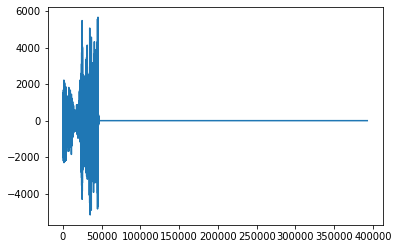

In [ ]:
# Plotting a sample waveform
plt.plot(samples[: , 0])

In [ ]:
# wav_list = [wavfile.read(fname)[1] for fname in pad_audio_paths]

In [35]:
# What shapes does 95% of the wav array covers? 
#pad_ms = int(np.percentile(wav_shape_list , 95))



Alright now we got the shapes of each waveform tensor and also got the 95% percentile of whats the majority spread. 
- Now I have to pad the arrays of size < `pad_ms` with 0s. 
- If the array is > `pad_ms` then I will slice that array till the `pad_ms` value. 
- Append that to a list. 

In [25]:
from tqdm import tqdm
# Using some multiprocessing to speed up the list comprehension

In [26]:
# Reading the wavfile and reshaping them depending upon the dimensions atlast storing them in a list 

data =  Parallel(n_jobs= -1)(delayed(wav_reader)(filename) for filename in pad_audio_paths)

In [27]:
# # Zero pad the shorted samples and cut off the long ones 
# pad_data = []
# for wav in data:
#   if wav.size < pad_ms:
#     d = np.pad(wav , (int(pad_ms - wav.size) , 0) , mode= 'constant')
#   else: 
#     d = wav[0:pad_ms]
#   pad_data.append(d)

# pad_data

#### Converting the waveforms into Spectrogram (also change the dtype of the list of arrays)


In [ ]:
from scipy import signal 

one , two , three  = signal.spectrogram(pad_data[1].astype(np.float32) , nperseg= 256 , 
                   noverlap = 128)

In [ ]:
one.shape , two.shape , three.shape

((129,), (6136,), (129, 6136))

In [ ]:
129 * 6136

791544

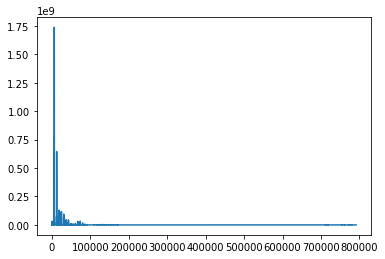

In [ ]:
dum = np.reshape(three , newshape = (-1))
plt.plot(dum)

In [ ]:
# Using the function from older notebook (takes log of the spectrogram)


def log_spectrogram

In [ ]:
# Working perfectly!!
from IPython.display import Audio 
Audio(pad_data[8] , rate = 44100 + 44100)

In [ ]:
# Lets try to build a simple dense 

### Model 1: A simple dense model 

In [ ]:
# # Creating the data pipelines 

# labels = new_df['emotion'].to_numpy()
# audio_ds = tf.data.Dataset.from_tensor_slices(pad_data)
# label_ds = tf.data.Dataset.from_tensor_slices(labels)

# # Zipping them together 
# train_ds = tf.data.Dataset.zip((audio_ds , label_ds))
# train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# train_ds

In [170]:
# Lets encode our labels 
label_df = pd.DataFrame(labels)
label_df

,0
0,neutral
1,neutral
2,joy
3,neutral
4,neutral
...,...
5258,neutral
5259,neutral
5260,fear
5261,neutral


In [171]:
# Convertiing class labels into categorical label 
from sklearn import  preprocessing 

le = preprocessing.LabelEncoder()
le.fit(label_df[0])

label_df['cat_label'] = le.transform(label_df[0])

In [177]:
spec_ds = tf.data.Dataset.from_tensor_slices(spec_copy)
spec_ds

<TensorSliceDataset shapes: (890, 442), types: tf.float32>

In [178]:
label_ds  = tf.data.Dataset.from_tensor_slices(label_df['cat_label'].to_numpy())

spec_ds = spec_ds.batch(16).prefetch(tf.data.AUTOTUNE)

In [179]:
spec_ds

<PrefetchDataset shapes: (None, 890, 442), types: tf.float32>

In [180]:
train_ds = tf.data.Dataset.zip((spec_ds , label_ds))
train_ds

<ZipDataset shapes: ((None, 890, 442), ()), types: (tf.float32, tf.int64)>

In [54]:
# # Splitting into train and validation splits 
# split_size = int(len(pad_data) * 0.8)
# label = train_df_new['cat_label'].to_list()

# train_audio = pad_array[:split_size]
# train_labels = label[:split_size]

# val_audio = pad_array[split_size:]
# val_labels = pad_data[split_size:]

# len(train_audio) , len(val_audio) , len(train_labels) , len(val_labels)

(4652, 1163, 4652, 1163)

In [182]:
# Building a simple dense model
input_shape = spec_copy[0].shape
num_classes = len(label_df.cat_label.value_counts())


inputs = layers.Input(shape = [890 , 442])
x = layers.Dense(128 , activation= 'relu')(inputs)
x = layers.Dense(64 , activation= 'relu')(x)
outputs = layers.Dense(num_classes , activation= 'softmax')(x)

# Packing into a model 
model_1 = tf.keras.Model(inputs,  outputs , name = 'model_1_dense')
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 890, 442)]        0         
_________________________________________________________________
dense (Dense)                (None, 890, 128)          56704     
_________________________________________________________________
dense_1 (Dense)              (None, 890, 64)           8256      
_________________________________________________________________
dense_2 (Dense)              (None, 890, 7)            455       
Total params: 65,415
Trainable params: 65,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilling the model 
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fitting the model 
history_1 = model_1.fit(train_ds ,  
                        epochs = 3 )

### Making Zip archives for the directories and loading them on the Colab Instance. 

In [41]:
stripped_audio_path = '/content/drive/MyDrive/Cogito_ai/pad_wav_files'
wav_files_path = '/content/drive/MyDrive/Cogito_ai/train_wav_files/TrainAudioFiles'

# Checking the amount of files inside the dir (5815)
len(os.listdir(stripped_audio_path)) , len(os.listdir(wav_files_path))

(5815, 5815)

In [42]:
import shutil 
from shutil import make_archive

In [44]:
make_archive?